<a href="https://colab.research.google.com/github/MarMolinaF/Python-Intro-for-Data-Science/blob/main/Challenge_M%C3%B3dulo_5_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge

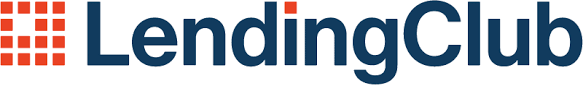

*Lending Club es una compañía estadounidense de préstamo entre particulares, con sede en San Francisco.*

Este dataset contiene datos para todos los préstamos emitidos durante el período 2007-2011, incluido el estado actual del préstamo (actual, cancelado, totalmente pagado, etc.) y la información de pago más reciente.

## **Objetivo**

Encuentra el modelo y su conjunto de hiperparámetros que mejor predicen si un crédito tiene o no riesgo


* **grade**: calificación del préstamo
* **sub_grade**: subgrado del préstamo
* **short_emp**: un año o menos de empleo del prestatario
* **emp_length_num**: número de años de empleo  del prestatario
* **home_ownership**: estado de propiedad de vivienda: propio (own), hipoteca (mortgage) o alquiler(rent)
* **dti**: relación deuda-ingresos
* **purpose**: propósito del préstamo
* **term**: plazo del préstamo
* **last_delinq_none**: ¿el prestatario ha tenido algún impago?
* **last_major_derog_none**: ¿el prestatario ha tenido una calificación de 90 días o peor?
* **revol_util**: porcentaje de crédito disponible utilizado
* **total_rec_late_fee**: total de cargos por pagos atrasados recibidos hasta la fecha

Target/Objetivo de predicción:
* **bad_loans**: (+1 significa crédito riesgo, 0 es seguro)

## Funciones

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Hacer print con el texto en negrita
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [5]:
# Creamos una función que imprime por pantalla características importantes de los datos
def inspect_data(df):
    printmd('Data Shape')
    print(df.shape)
    print('\n')
    printmd('Missing Values: ')
    print(df.isnull().sum())
    print('\n')
    printmd('Data Types: ')
    print(df.dtypes)

In [6]:
def plottingRegressComparison(yreal,ypred):

    comparison = pd.DataFrame({"yreal":yreal, "ypred":ypred})

    i=min(ypred)
    comparison["line"] = [i+j*max(yreal)/len(comparison) for j in range(len(comparison))]
    comparison["line2"] = comparison["line"]

    fig, ax = plt.subplots(figsize=(8,8))
    comparison.plot(x="line", y="line2", ax=ax, color="red", marker="*", markersize=2)
    comparison.plot.scatter(x="yreal", y="ypred", ax=ax)
    ax.grid(True)
    ax.set_yticklabels(ax.get_yticks(minor=False), fontname='Serif', fontsize=10)
    ax.set_xticklabels(ax.get_xticks(minor=False), fontname='Serif', fontsize=10)
    ax.set_ylabel("Ventas predichas", fontname='Serif', fontsize=10)
    ax.set_xlabel("Ventas reales", fontname='Serif', fontsize=10)
    ax.set_title("Ventas reales VS Ventas predichas", fontname='Serif', fontsize=10)
    ax.get_legend().remove()

In [7]:
def plottingResults(yreal,ypred):
    # Creamos
    comparison = pd.DataFrame({"yreal":yreal, "ypred":ypred})
    comparison["diff"] = comparison["yreal"] - comparison["ypred"]

    fig, ax = plt.subplots(figsize=(8,8))
    comparison["diff"].hist(bins=100, ax=ax)
    ax.set_xticklabels(ax.get_xticks(),fontsize=10, rotation=45)
    ax.set_yticklabels(ax.get_yticks(),fontsize=10)
    ax.set_xlabel("Error", fontname='Serif', fontsize=10)
    ax.set_title("Histograma del error de predicción", fontname='Serif', fontsize=16)

# **Preprocessing Data Functions**

## Missing data

In [8]:
def meanValueImputation(data, feature):
    """
    Completa los valores vacíos en una columna de un DataFrame con el valor medio de esa columna.

    :param data: DataFrame en el que se encuentra la columna.
    :param columna: Nombre de la columna que se desea completar.
    """
    # Calcula el valor medio de la columna
    valor_medio = data[feature].mean()

    # Completa los valores vacíos con el valor medio
    data[feature].fillna(valor_medio, inplace=True)

In [9]:
from scipy import stats
def modeValueImputation(data, feature):

    """
    Completa los valores vacíos en una columna de un DataFrame con el valor moda de esa columna.

    :param data: DataFrame en el que se encuentra la columna.
    :param columna: Nombre de la columna que se desea completar.
    """
    # Calcula el valor moda de la columna
    valor_moda = stats.mode(data[feature])[0][0]

    # Completa los valores vacíos con el valor moda
    data[feature].fillna(valor_moda, inplace=True)

In [10]:
def mostCommonValueImputation(data, feature):

    """
    Completa los valores vacíos en una columna categórica de un DataFrame con el valor más común (modo) de esa columna.

    :param data: DataFrame en el que se encuentra la columna.
    :param columna: Nombre de la columna que se desea completar.
    """
    # Calcula el valor más común (modo) de la columna
    valor_mas_comun = data[feature].mode()[0]

    # Completa los valores vacíos con el valor más común
    data[feature].fillna(valor_mas_comun, inplace=True)

## Outliers

In [11]:
def statisticalOutlierDetection(data, feature, thresholdmin=None,thresholdmax=None, drop=False):
  #Eliminamos outliers en base a un criterio estadístico
  if thresholdmax:
    print("dentro")
    data_clean = data.drop(data[data[feature]>=thresholdmax].index)
  else:
    data_clean = data.copy()

  if thresholdmin:
    data_clean = data_clean.drop(data_clean[data_clean[feature]<=thresholdmin].index)
  else:
    data_clean = data_clean.copy()

  data_clean.reset_index(drop=True, inplace=True)

  print("Se han eliminado : {} instancias.".format(len(data)-len(data_clean)))
  print(data_clean.shape)

  if drop==True:
    return data_clean
  else:
    return data

In [12]:
def modelOutlierDetection(data, nf, n = 20, drop = False):
  ## LocalOutlierFactor: se basa en la idea de que las instancias de datos anómalas tienen una densidad de puntos diferente a la de las instancias de datos normales en su vecindario local.
  from sklearn.neighbors import LocalOutlierFactor
  # Creamos el objeto LOF y ajustamos los datos
  clf = LocalOutlierFactor(n_neighbors=n)  # número de vecinos más cercanos que se considerarán al calcular la densidad local de un punto de datos.
  y_pred = clf.fit_predict(np.array(nf))
  # Eliminamos los outliers de nuestro set de datos
  data_clean = data.copy()
  data_clean["outliers"] = y_pred
  data_clean.drop(data_clean[data_clean["outliers"]<0].index, inplace=True)
  data_clean.drop("outliers", axis=1, inplace=True)
  data_clean.reset_index(drop=True, inplace=True)
  print("Se han eliminado : {} instancias.".format(len(data)-len(data_clean)))

  if drop:
    return  data_clean
  else:
    return data

## Codificación

In [13]:
from sklearn.preprocessing import LabelEncoder
def labelEncoding(data, categorical_features):
  # Defino mi modelo de codificación
  le = LabelEncoder()
  data_cod = data.copy() # Creo un dataframe de plantilla porque no quiero modificar el original
  for col in categorical_features.columns:
      data_cod[col+"_cod"]=le.fit_transform(np.array(data_cod[col]))

  data_cod = data_cod.drop(categorical_features.columns, axis=1)

  return data_cod

In [14]:
##data_cod = labelEncoding(data, ["grade", "subgrade"])

In [15]:
from sklearn.preprocessing import OneHotEncoder
def OHEncoding(data, categorical_features):
  ohe = OneHotEncoder()
  data_cod = data.copy()
  for col in categorical_features.columns:
    # Data a codificar
    X = np.array(data_cod[[col]])
    # Fit & transform
    ohe.fit(X)
    Xohe = ohe.transform(X).toarray()
    # Unimos al set de datos de partida
    dataohe = pd.DataFrame(Xohe, columns=data_cod[col].drop_duplicates().tolist())
    data_cod = pd.concat([data_cod,dataohe], axis=1)

  # Eliminamos las variables originales de nuestro set de datos
  data_cod = data_cod.drop(categorical_features.columns, axis=1)

  return data_cod

In [16]:
!pip install category_encoders
import category_encoders as ce
def binaryEncoding(data, categorical_features):
  # Defino mi modelo de codificación
  data_cod = data.copy()
  # Creamos el objeto BinaryEncoder y ajustamos el dataframe
  encoder = ce.BinaryEncoder(cols=categorical_features)
  data_cod = encoder.fit_transform(data_cod)
  data_cod

  return data_cod

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.2 MB/s eta 0:00:00


# Challenge notebook

## Importamos las librerías que vamos a utilizar

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

## Carga y previsualización de datos

In [18]:
data = pd.read_csv("challenge-lending_club_data_train.csv")

In [19]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


## Análisis de los datos

In [20]:
inspect_data(data)

Data Shape

(80000, 68)




Missing Values: 

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                        ..
payment_inc_ratio        4
final_d                  0
last_delinq_none         0
last_record_none         0
last_major_derog_none    0
Length: 68, dtype: int64




Data Types: 

id                         int64
member_id                  int64
loan_amnt                  int64
funded_amnt                int64
funded_amnt_inv            int64
                          ...   
payment_inc_ratio        float64
final_d                   object
last_delinq_none           int64
last_record_none           int64
last_major_derog_none      int64
Length: 68, dtype: object


### Analizamos el target

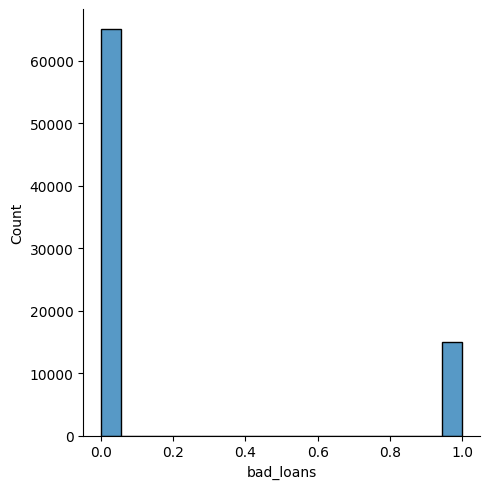

In [21]:
sns.displot(data["bad_loans"])

### Analizamos variables categóricas

In [22]:
categorical_features = data.select_dtypes(include=[object])
categorical_features.head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,is_inc_v,issue_d,loan_status,pymnt_plan,...,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,status,final_d
0,36 months,B,B2,NaN,10+ years,RENT,Verified,20111201T000000,Fully Paid,n,...,Computer,860xx,AZ,19850101T000000,f,20150101T000000,NaN,20150101T000000,Fully Paid,20141201T000000
1,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,20111201T000000,Charged Off,n,...,bike,309xx,GA,19990401T000000,f,20130401T000000,NaN,20130901T000000,Charged Off,20161201T000000
2,36 months,C,C5,NaN,10+ years,RENT,Not Verified,20111201T000000,Fully Paid,n,...,real estate business,606xx,IL,20011101T000000,f,20140601T000000,NaN,20150201T000000,Fully Paid,20141201T000000
3,36 months,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,20111201T000000,Fully Paid,n,...,personel,917xx,CA,19960201T000000,f,20150101T000000,NaN,20150101T000000,Fully Paid,20141201T000000
4,36 months,A,A4,Veolia Transportaton,3 years,RENT,Source Verified,20111201T000000,Fully Paid,n,...,My wedding loan I promise to pay back,852xx,AZ,20041101T000000,f,20150101T000000,NaN,20150201T000000,Fully Paid,20141201T000000


In [23]:
categorical_features.sort_values("loan_status").head(20)

,term,grade,sub_grade,emp_title,emp_length,home_ownership,is_inc_v,issue_d,loan_status,pymnt_plan,...,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,status,final_d
61254,36 months,B,B1,William Paradiso & Associates,10+ years,RENT,Not Verified,20130501T000000,Charged Off,n,...,Club Lend,115xx,NY,19881001T000000,f,20140201T000000,NaN,20140701T000000,Charged Off,20160501T000000
66698,60 months,E,E2,dtla motors,7 years,RENT,Verified,20130401T000000,Charged Off,n,...,credit card pay,900xx,CA,19970701T000000,f,20131001T000000,NaN,20140101T000000,Charged Off,20180401T000000
66697,36 months,C,C5,Stations Casinos,4 years,RENT,Not Verified,20130401T000000,Charged Off,n,...,Furniture,891xx,NV,19990501T000000,w,20140101T000000,NaN,20140601T000000,Charged Off,20160401T000000
66695,36 months,D,D1,Florida A&M University,< 1 year,MORTGAGE,Source Verified,20130401T000000,Charged Off,n,...,Consolidate,325xx,FL,19900701T000000,f,20140101T000000,NaN,20150101T000000,Charged Off,20160401T000000
50869,60 months,C,C5,Dartmouth College,5 years,MORTGAGE,Verified,20130801T000000,Charged Off,n,...,Credit Card Consolidation,037xx,NH,20060601T000000,f,20140901T000000,NaN,20150101T000000,Charged Off,20180801T000000
66688,36 months,C,C2,The Mclaughlin Company,10+ years,RENT,Not Verified,20130401T000000,Charged Off,n,...,Loan,222xx,VA,19990701T000000,f,20140801T000000,NaN,20150201T000000,Charged Off,20160401T000000
50876,36 months,F,F1,gregs electrical services,3 years,MORTGAGE,Not Verified,20130901T000000,Charged Off,n,...,credit free,217xx,MD,20040501T000000,f,20140901T000000,NaN,20150201T000000,Charged Off,20160901T000000
34223,36 months,B,B1,ITO VIDEO,9 years,MORTGAGE,Not Verified,20081001T000000,Charged Off,n,...,New Cabinets for my KITCHEN,917xx,CA,19951201T000000,f,20091201T000000,NaN,20100401T000000,Charged Off,20111001T000000
34222,36 months,A,A4,sunpass,< 1 year,OWN,Verified,20081001T000000,Charged Off,n,...,personal loan,328xx,FL,20010601T000000,f,20100201T000000,NaN,20100701T000000,Charged Off,20111001T000000
15938,60 months,C,C5,krugel cobbles,5 years,OWN,Not Verified,20110301T000000,Charged Off,n,...,equipment for pub,600xx,IL,19960101T000000,f,20110401T000000,NaN,20110901T000000,Charged Off,20160301T000000


In [24]:
categorical_features.apply(lambda x: x.nunique())

,0
term,2
grade,7
sub_grade,35
emp_title,54462
emp_length,11
home_ownership,4
is_inc_v,3
issue_d,69
loan_status,5
pymnt_plan,1


In [25]:
categorical_features.apply(lambda x: x.value_counts().shape)

,term,grade,sub_grade,emp_title,emp_length,home_ownership,is_inc_v,issue_d,loan_status,pymnt_plan,...,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,status,final_d
0,2,7,35,54462,11,4,3,69,5,1,...,29814,856,50,576,2,87,89,92,3,89


In [26]:
categorical_features.apply(lambda x: x.unique())

,0
term,"[ 36 months, 60 months]"
grade,"[B, C, A, E, F, D, G]"
sub_grade,"[B2, C4, C5, C1, A4, E1, F2, B5, C3, B1, D1, A..."
emp_title,"[nan, Ryder, AIR RESOURCES BOARD, Veolia Trans..."
emp_length,"[10+ years, < 1 year, 3 years, 9 years, 4 year..."
home_ownership,"[RENT, OWN, MORTGAGE, OTHER]"
is_inc_v,"[Verified, Source Verified, Not Verified]"
issue_d,"[20111201T000000, 20111101T000000, 20111001T00..."
loan_status,"[Fully Paid, Charged Off, Default, Does not me..."
pymnt_plan,[n]


In [41]:
data.drop(["emp_title",
          "emp_length",
          "is_inc_v",
          "issue_d",
          "loan_status",
          "pymnt_plan",
          "url",
          "desc",
          "title",
          "zip_code",
          "addr_state",
          "earliest_cr_line",
          "initial_list_status",
          "last_pymnt_d",
          "next_pymnt_d",
          "last_credit_pull_d",
          "status",
          "final_d"], axis=1, inplace=True)

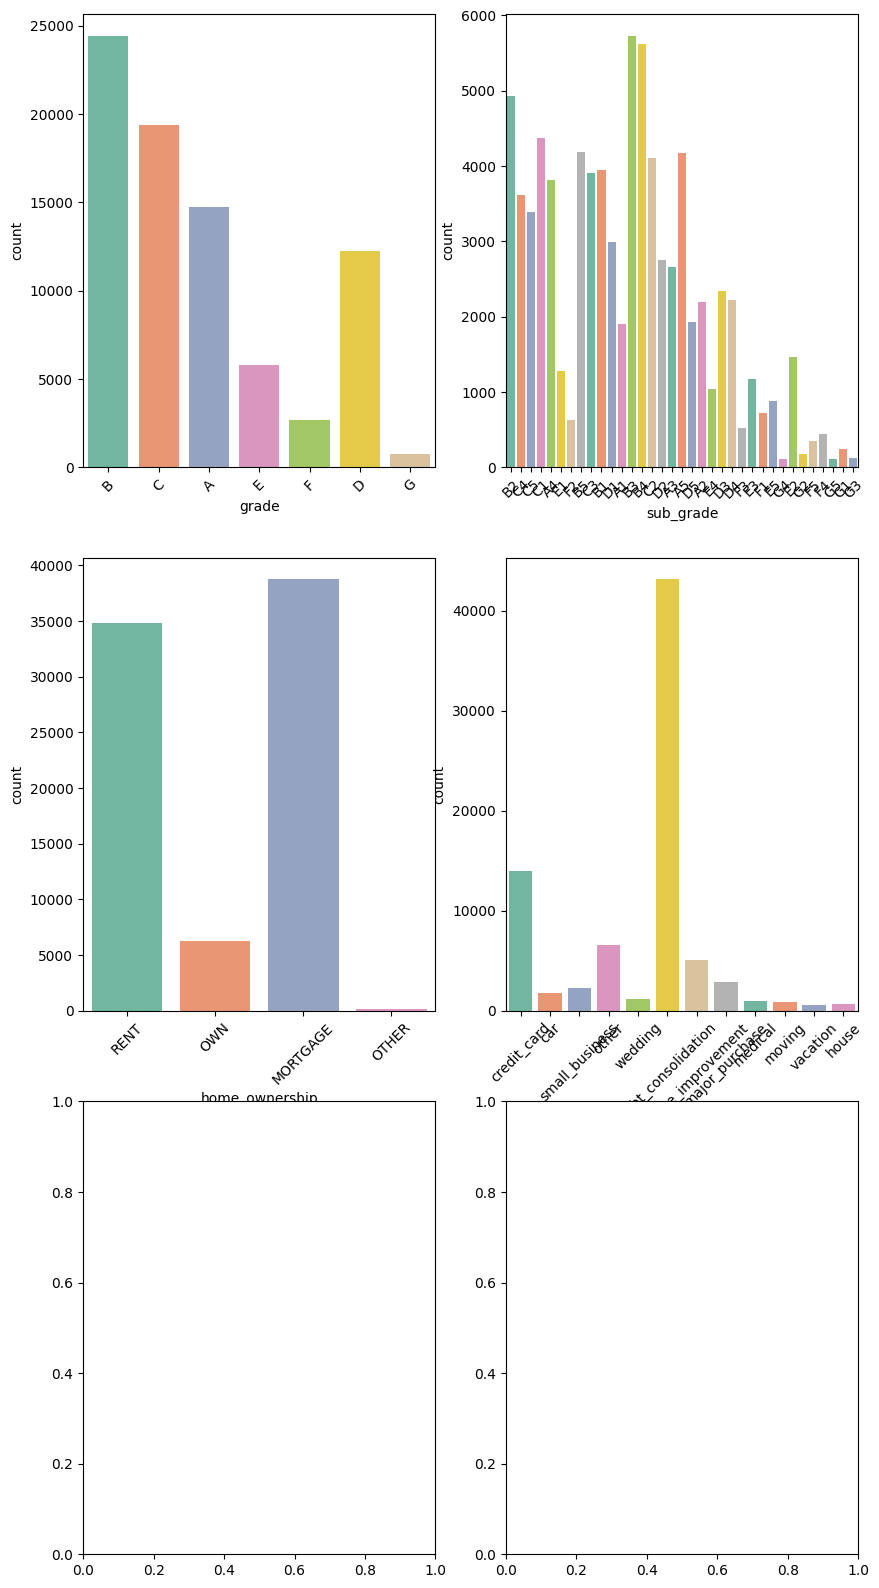

In [51]:
fig, axs = plt.subplots (3, 2, figsize =(10,20))
catdata = data.select_dtypes(include=['object']).columns
catdata = catdata[1:]
for col, ax in zip(catdata, axs.ravel()):
    sns.countplot(x=col,data=data,palette='Set2',ax=ax)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45,)



### Analizamos variables numéricas

In [52]:
numerical_features = data.select_dtypes(include=[np.number])
numerical_features.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,grade_num,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,10.65,162.87,24000.0,27.65,0.0,...,5,0.4,1.0,1.0,1.0,0,8.14350,1,1,1
1,1077430,1314167,2500,2500,2500,15.27,59.83,30000.0,1.00,0.0,...,4,0.8,1.0,1.0,1.0,1,2.39320,1,1,1
2,1077175,1313524,2400,2400,2400,15.96,84.33,12252.0,8.72,0.0,...,4,1.0,1.0,1.0,1.0,0,8.25955,1,1,1
3,1076863,1277178,10000,10000,10000,13.49,339.31,49200.0,20.00,0.0,...,4,0.2,1.0,1.0,1.0,0,8.27585,0,1,1
4,1075269,1311441,5000,5000,5000,7.90,156.46,36000.0,11.20,0.0,...,6,0.8,1.0,1.0,1.0,0,5.21533,1,1,1


In [53]:
data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,grade_num,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,last_delinq_none,last_record_none,last_major_derog_none
count,8.000000e+04,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,7.999600e+04,80000.000000,79971.000000,...,80000.000000,80000.000000,79971.000000,79971.000000,79855.000000,80000.000000,79996.000000,80000.000000,80000.000000,80000.000000
mean,3.221520e+06,3.883806e+06,12509.563438,12400.805313,12045.176675,13.467045,385.442230,7.135391e+04,15.064076,0.203486,...,4.238300,0.599420,0.860775,0.911568,0.997546,0.127587,7.375736,0.590562,0.895663,0.888988
std,2.925187e+06,3.508007e+06,7839.056266,7769.497087,7850.350561,4.355803,235.886562,6.393560e+04,7.420169,0.632788,...,1.371062,0.278316,0.346184,0.283924,0.049482,0.333632,4.087201,0.491733,0.305700,0.314150
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.028895,0.000000,0.000000,0.000000
25%,6.428395e+05,8.227158e+05,6300.000000,6250.000000,6000.000000,10.370000,205.280000,4.400000e+04,9.500000,0.000000,...,3.000000,0.400000,1.000000,1.000000,1.000000,0.000000,4.216670,0.000000,1.000000,1.000000
50%,2.301091e+06,2.641987e+06,10375.000000,10050.000000,10000.000000,13.110000,338.930000,6.000000e+04,14.830000,0.000000,...,4.000000,0.600000,1.000000,1.000000,1.000000,0.000000,6.763780,1.000000,1.000000,1.000000
75%,5.765242e+06,7.018737e+06,17000.000000,16800.000000,16000.000000,16.290000,510.660000,8.500000e+04,20.410000,0.000000,...,5.000000,0.800000,1.000000,1.000000,1.000000,0.000000,9.963000,1.000000,1.000000,1.000000
max,1.023481e+07,1.209696e+07,35000.000000,35000.000000,35000.000000,26.060000,1408.130000,7.141778e+06,34.990000,29.000000,...,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,54.171000,1.000000,1.000000,1.000000


In [54]:
numerical_features.apply(lambda x: x.unique())

,0
id,"[1077501, 1077430, 1077175, 1076863, 1075269, ..."
member_id,"[1296599, 1314167, 1313524, 1277178, 1311441, ..."
loan_amnt,"[5000, 2500, 2400, 10000, 3000, 5600, 5375, 65..."
funded_amnt,"[5000, 2500, 2400, 10000, 3000, 5600, 5375, 65..."
funded_amnt_inv,"[4975, 2500, 2400, 10000, 5000, 3000, 5600, 53..."
int_rate,"[10.65, 15.27, 15.96, 13.49, 7.9, 18.64, 21.28..."
installment,"[162.87, 59.83, 84.33, 339.31, 156.46, 109.43,..."
annual_inc,"[24000.0, 30000.0, 12252.0, 49200.0, 36000.0, ..."
dti,"[27.65, 1.0, 8.72, 20.0, 11.2, 5.35, 5.55, 18...."
delinq_2yrs,"[0.0, 2.0, 3.0, 1.0, 4.0, 6.0, 5.0, 8.0, 7.0, ..."


In [55]:
numerical_features.apply(lambda x: x.nunique())

,0
id,80000
member_id,80000
loan_amnt,1107
funded_amnt,1149
funded_amnt_inv,6813
int_rate,464
installment,25156
annual_inc,8374
dti,3476
delinq_2yrs,16


In [58]:
data.drop(["id",
           "member_id",
           "funded_amnt",
           "funded_amnt_inv",
           "installment",
           "inq_last_6mths",
           "mths_since_last_delinq",
           "mths_since_last_record",
           "pub_rec",
           "revol_bal",
           "total_acc",
           "out_prncp",
           "out_prncp_inv",
           "total_pymnt",
           "total_pymnt_inv",
           "total_rec_prncp",
           "total_rec_int",
           "recoveries",
           "collection_recovery_fee",
           "last_pymnt_amnt",
           "collections_12_mths_ex_med",
           "mths_since_last_major_derog",
           "policy_code",
           "not_compliant",
           "inactive_loans",
           "grade_num",
           "sub_grade_num",
           "pub_rec_zero",
           "collections_12_mths_zero",
           "payment_inc_ratio",
           "last_record_none"], axis=1, inplace=True)


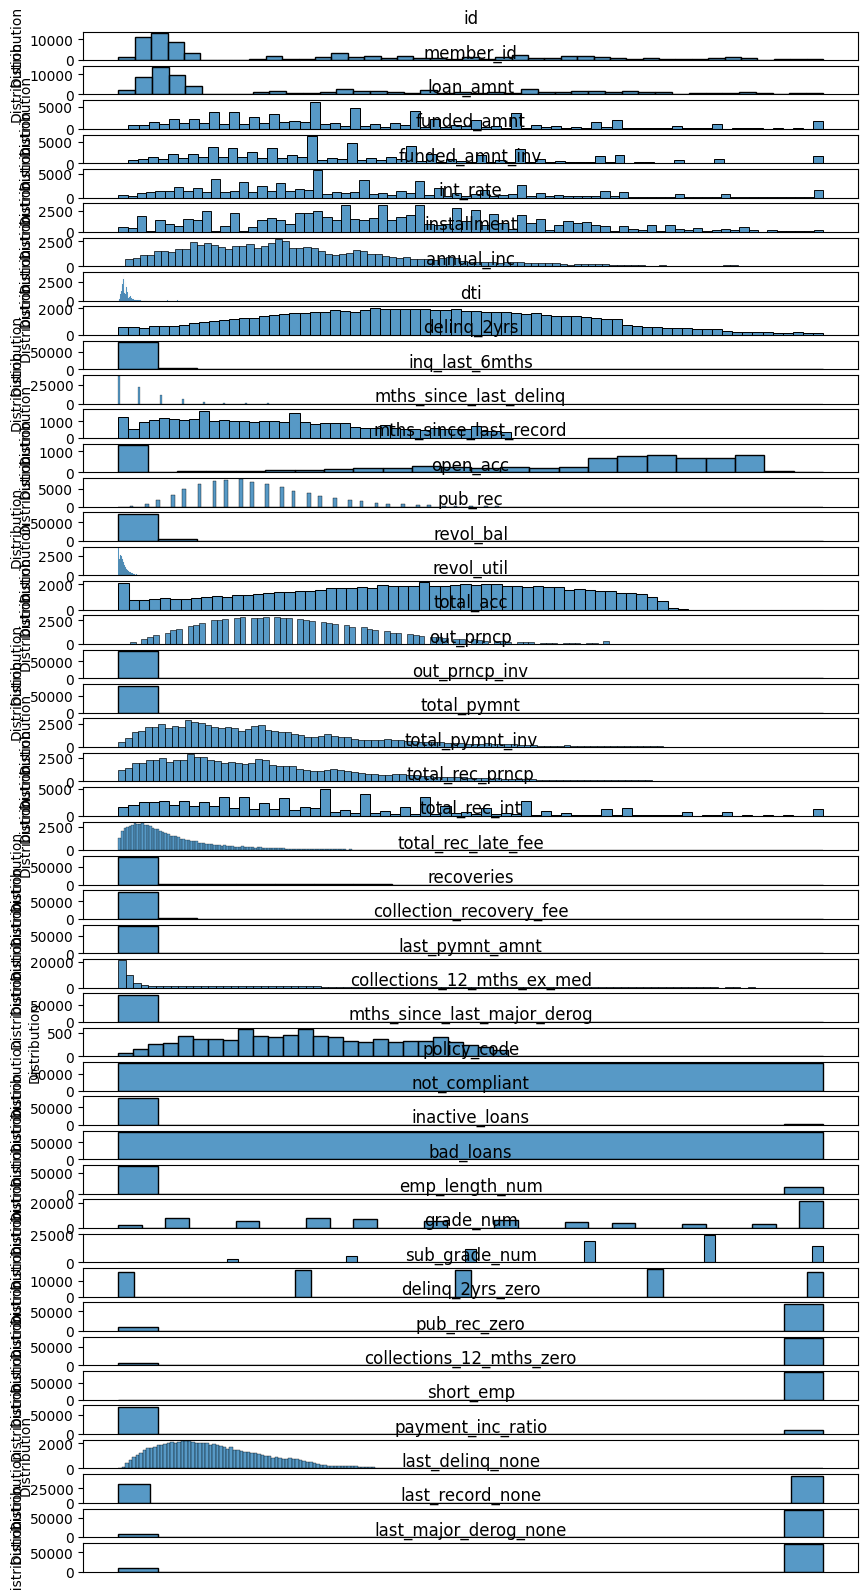

In [62]:
cols = numerical_features.columns
fig, axs = plt.subplots(len(cols),1,figsize=(10,20))
for col, ax in zip(cols, axs.ravel()):
    sns.histplot(data=numerical_features[col], ax=ax)
    ax.set_ylabel("Distribution")
    ax.get_xaxis().set_visible(False)
    ax.set_title(col)

## Modelado 1

### Procesamiento de los datos

#### Balanceo del target

#### Imputación y outliers

#### Codificación

#### Escalado

### Particion de los datos

### Evaluación preliminar de los modelos

### Crossvalidamos los mejores

### Ajustamos los hiperparámetros del mejor

## Modelado 2

## Modelado 3

## Evaluación final

¡Al final! Cálcula la predicción con tu mejor modelo entrenado y envíalo a rubencpardo@gmail.com

RECUERDA: a los datos de evaluación del challenge tendrás que aplicarle previamente los mismos pasos de preprocesamiento que hayas utilizado para entrenar tu mejor modelo predictivo:
* Eliminación de variables
* Escalado
* Codificación


# ¿Cómo guardar los resultados de la evaluación para enviarlos?

In [ ]:
# Si es un numpy array
y_results = pd.DataFrame({"results": y_results})
y_results.to_csv("module5-challenge-tunombre.csv", index=False)

Descagarlo

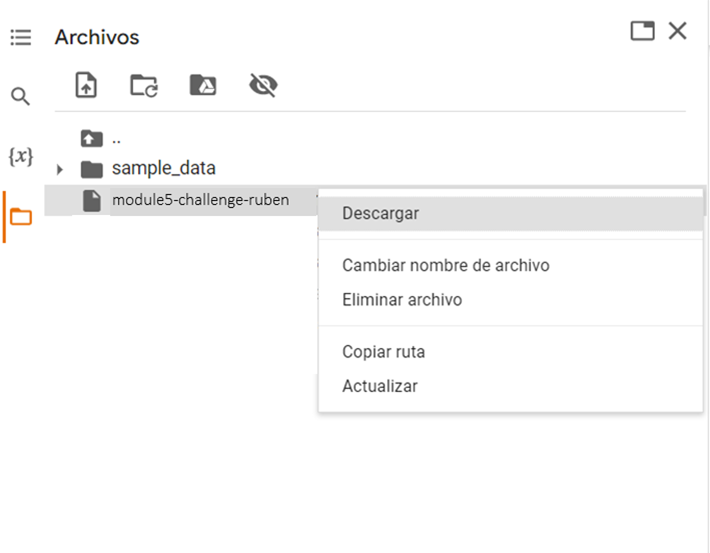

**¡Cuidado! Se puede bloquear la descarga de archivos desde Colab, tienes que permitirlo.**



-
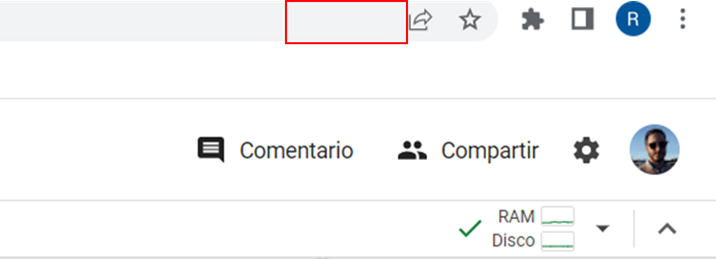